In [1]:
import os
import collections
import json
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 20)
pd.options.display.max_rows = 100

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import langid
from src.wimbd_ import WimbdAnalysis, WimbdTasks, display_language_pairs, filter_percentile, load_results

[nltk_data] Downloading package punkt to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /local/home/antonis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[dynet] random seed: 1234
[dynet] allocating memory: 32MB
[dynet] memory allocation done.


In [3]:
# lang params
N_GRAMS = 2
BASE_DIR = f"./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue"
# LANG_DF_PTH = "./results/n-grams/exp_full/2/examples_dfs_0-shot_common_models.pkl"
LANG_DF_PTH = f"./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/{N_GRAMS}/examples_dfs_0-shot_common_models.pkl"
# LANG_DF_PTH = f"./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/{N_GRAMS}/examples_dfs_0-shot_all_models.pkl"
# LANG_DF_PTH = f"./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/{N_GRAMS}/all/lang_dfs_is_allTrue_filter_charsFalse_percentile0_detect_langTrue_filter_entitiesTrue_filter_stopwordsTrue_remove_englishTrue_remove_non_englishFalse.pkl"
# LANG_DF_PTH = f"./results/n-grams/europarl/pile/exp4/n_samples_20000_fkeyFalse_rkeyFalse_fstopFalse_onlyalphaTrue/{N_GRAMS}/common/lang_dfs_filter_charsFalse_percentile0_detect_langFalse_filter_entitiesTrue_filter_stopwordsTrue_align_langs0.pkl"
# LANG_DF_PTH = f"./results/n-grams/exp_full/"

BASE_PATH = os.path.join(BASE_DIR, str(N_GRAMS))
BASE_PATH_COMMON = os.path.join(BASE_PATH, "common")
BASE_PATH_ALL = os.path.join(BASE_PATH, "all")
FILTER_CHARS = False
DETECT_LANG = False
PERCENTILE = 0.95
TASK = 'TRANSLATION'
ALIGN_SCORE = 0.75

# model params
base_results_path = "/share/edc/home/antonis/LLM-Incidental-Supervision/incidental-supervision/models/experiment_6_logits_max_4/inference/EleutherAI"
models = ['pythia-12b', 'pythia-6.9b', 'pythia-2.8b', 'pythia-1.4b', 'pythia-410m', 'pythia-160m', 'pythia-70m', 'pythia-31m', 'pythia-14m',]

# wmt09
LANGUAGES = ['wmt09-cs-en', 'wmt09-de-en', 'wmt09-fr-en', 'wmt09-es-en', 'wmt09-it-en', 'wmt09-hu-en']

# LANGUAGES = ['wmt09-en-cs', 'wmt09-en-de', 'wmt09-en-fr', 'wmt09-en-es', 'wmt09-en-it', 'wmt09-en-hu',]
TASKS = [task.replace('wmt09-', '') for task in LANGUAGES]

wa = WimbdAnalysis(BASE_PATH, LANGUAGES, N_GRAMS, FILTER_CHARS)
wt = WimbdTasks()

LANGUAGES_STR = "_".join(LANGUAGES)
PLOT_PATH = f"./results/n-grams/exp_full/{N_GRAMS}/plots/{LANGUAGES_STR}_filter_{FILTER_CHARS}"
if not os.path.exists(PLOT_PATH):
    os.makedirs(PLOT_PATH)

In [4]:
bleu_scores = load_results(base_results_path, models, TASK, '0-shot', LANGUAGES,
                           calc_reverse=False)
bleu_scores_bi = load_results(base_results_path, models, TASK, '0-shot', LANGUAGES,
                           calc_reverse=True)
bleu_scores_0 = bleu_scores[list(bleu_scores.keys())[0]]

In [5]:
# lang_dfs_all_filtered = wa.get_lang_dfs(BASE_PATH_ALL, LANGUAGES, filter_chars=True,
#                                         percentile=0.95, detect_lang=False, filter_entities=True)

lang_dfs = pickle.load(open(LANG_DF_PTH, 'rb'))
lang_dfs_1 = pickle.load(open(LANG_DF_PTH, 'rb'))

def filter_align_score(lang_df, align_score=0.8):
    lang_df = {model: df[df['alignment_score'] >= align_score] for model, df in lang_df.items()}
    return lang_df

lang_dfs = filter_align_score(lang_dfs, align_score=ALIGN_SCORE)

if 'pythia-12b' in lang_dfs:
    lang_df_0 = lang_dfs['pythia-12b']
    lang_df = lang_df_0
else:
    lang_df_0 = lang_dfs[list(lang_dfs.keys())[0]]
    lang_df = pd.concat(lang_dfs).reset_index(drop=True)
    lang_dfs = {model: lang_df for model in models}

lang_dfs = {lang: filter_percentile(df, PERCENTILE) for lang, df in lang_dfs.items()}
lang_dfs_0 = lang_dfs[list(lang_dfs.keys())[0]]
    
# get total samples per language pair
lang_dfs_total_samples = {task: lang_dfs_0[lang_dfs_0['task'] == task]['value'].sum() for task in lang_dfs_0['task'].unique()}
colors = sns.color_palette('husl', len(TASKS))
color_mapping = {lang: color for lang, color in zip(TASKS, colors)}

# Define country-specific colors
country_colors = {
    'fr-en': '#0055A4',   # France - Blue
    'es-en': '#FF9900',   # Spain - Orange
    'it-en': '#008C45',   # Italy - Green
    'de-en': '#FFCC00',   # Germany - Yellow
    'cs-en': '#D7141A',   # Czech Republic - Red
    'hu-en': '#8B4513'    # Hungary - SaddleBrown
}


# Map the language pairs to their respective colors
color_mapping = {lang: country_colors[lang] for lang in TASKS}

In [6]:
lang_dfs['pythia-12b']['task'].unique()

array(['fr-en', 'it-en', 'es-en', 'de-en', 'cs-en', 'hu-en'], dtype=object)

In [7]:
lang_dfs['pythia-12b']

,lang_1,lang_2,value,example,task,pair,example_clean,docs,coverage,query,sum,count,id,gold,src,ref,result,bleu,alignment_score
0,minutes plus,minutes long,321,{'translation': {'en': 'We had to go very earl...,fr-en,"(minutes plus, minutes long)",A part le fait qu'il faut y aller très tôt pou...,"[train/08.jsonl.gz-967144, train/09.jsonl.gz-9...",0.072131,{'translation': {'en': 'We had to go very earl...,322,2,1835_8,0,We had to go very early to collect the chip bu...,A part le fait qu'il faut y aller très tôt pou...,Nous devions aller très tôt pour récupérer le...,22.372598,0.844945
1,cinque minuti,five minutes,319,{'translation': {'en': 'She missed the Beijing...,it-en,"(cinque minuti, five minutes)",Si è persa i Giochi di Pechino con quello che ...,"[train/03.jsonl.gz-1756686, train/07.jsonl.gz-...",0.047121,{'translation': {'en': 'She missed the Beijing...,326,3,2670_10,0,She missed the Beijing Games with what was des...,Si è persa i Giochi di Pechino con quello che ...,Ha perso le Olimpiadi del 2008 con una lesion...,16.403807,0.961103
2,droits fondamentaux,human rights,317,{'translation': {'en': 'Járóka also emphasized...,fr-en,"(droits fondamentaux, human rights)","Par ailleurs, Járóka a insisté sur le fait que...","[train/03.jsonl.gz-2891645, train/06.jsonl.gz-...",0.072131,{'translation': {'en': 'Járóka also emphasized...,390,7,1459_8,0,"Járóka also emphasized that education, as a fu...","Par ailleurs, Járóka a insisté sur le fait que...","Járóka also emphasized that education, as a f...",1.732811,0.857673
3,nueva versión,new version,313,{'translation': {'en': 'Listen to the four ren...,es-en,"(nueva versión, new version)",Escuche las cuatro presentaciones de la nueva ...,"[train/02.jsonl.gz-4737095, train/03.jsonl.gz-...",0.056007,{'translation': {'en': 'Listen to the four ren...,313,1,1906_9,0,Listen to the four renderings of the new versi...,Escuche las cuatro presentaciones de la nueva ...,Listen to the four renderings of the new vers...,2.627962,0.974183
4,mercados financieros,financial markets,312,{'translation': {'en': 'What we need in the lo...,es-en,"(mercados financieros, financial markets)",Se necesita a largo plazo que los estados miem...,"[train/27.jsonl.gz-3709837, train/05.jsonl.gz-...",0.056007,{'translation': {'en': 'What we need in the lo...,1535,4,2687_9,0,What we need in the long term is that the memb...,Se necesita a largo plazo que los estados miem...,Lo que necesitamos en el largo plazo es que l...,28.472621,0.971425
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6721,april juni,april june,1,{'translation': {'de': 'Von April bis Juni war...,de-en,"(april juni, april june)",Von April bis Juni waren die Preise aber schon...,[val.jsonl.gz-104001],0.038317,{'translation': {'de': 'Von April bis Juni war...,1,1,2466_1,0,Von April bis Juni waren die Preise aber schon...,"But from April to June, rates had already drop...",April to June were the prices down by 3.6 per...,15.761889,0.966974
6722,prix non,prices also,1,{'translation': {'en': 'The prices are also no...,fr-en,"(prix non, prices also)",Les prix ne sont pas non plus des plus bas.,[train/16.jsonl.gz-5830292],0.072131,{'translation': {'en': 'The prices are also no...,1,1,1550_8,0,The prices are also not among the lowest.,Les prix ne sont pas non plus des plus bas.,Les prix ne sont pas parmi les plus bas.,47.538527,0.756922
6723,animaux fait,many animals,1,{'translation': {'en': 'When a rat is in dange...,fr-en,"(animaux fait, many animals)","Lorsque un rat est devant un danger, il fait l...",[train/01.jsonl.gz-3617808],0.072131,{'translation': {'en': 'When a rat is in dange...,1,1,4_8,0,"When a rat is in danger, it does the same thin...","Lorsque un rat est devant un danger, il fait l...","Quand un rat est en danger, il fait la même c...",50.130535,0.791396
6724,procédures fiscales,fiscal code,1,{'translation': {'en': 'The decline in earning...,fr-en,"(procédures fiscales, fiscal code)",Et c'est seulement grâce au

In [8]:
for task in lang_df_0['task'].unique():
    lang_df_task = lang_df_0[lang_df_0['task'] == task]
    print(f"task: {task}")
    print(f"len rows: {len(lang_df_task)}")
    if 'query' in lang_df_task.columns:
        print(f"unique_examples: {len(lang_df_task['query'].unique())}")

task: cs-en
len rows: 927
unique_examples: 598
task: fr-en
len rows: 1988
unique_examples: 1064
task: hu-en
len rows: 469
unique_examples: 355
task: de-en
len rows: 983
unique_examples: 639
task: es-en
len rows: 1757
unique_examples: 986
task: it-en
len rows: 1416
unique_examples: 859


['cs-en', 'de-en', 'fr-en', 'es-en', 'it-en', 'hu-en']
model: pythia-12b, task: cs-en, score_key: cs-en
model: pythia-12b, task: de-en, score_key: de-en
model: pythia-12b, task: es-en, score_key: es-en
model: pythia-12b, task: fr-en, score_key: fr-en
model: pythia-12b, task: hu-en, score_key: hu-en
model: pythia-12b, task: it-en, score_key: it-en
model: pythia-6.9b, task: cs-en, score_key: cs-en
model: pythia-6.9b, task: de-en, score_key: de-en
model: pythia-6.9b, task: es-en, score_key: es-en
model: pythia-6.9b, task: fr-en, score_key: fr-en
model: pythia-6.9b, task: hu-en, score_key: hu-en
model: pythia-6.9b, task: it-en, score_key: it-en
model: pythia-2.8b, task: cs-en, score_key: cs-en
model: pythia-2.8b, task: de-en, score_key: de-en
model: pythia-2.8b, task: es-en, score_key: es-en
model: pythia-2.8b, task: fr-en, score_key: fr-en
model: pythia-2.8b, task: hu-en, score_key: hu-en
model: pythia-2.8b, task: it-en, score_key: it-en
model: pythia-1.4b, task: cs-en, score_key: cs-en
m

/tmp/ipykernel_3926920/1941353277.py:67: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  model_colormap = plt.cm.get_cmap('coolwarm', len(models))


Saved figure to ./results/n-grams/wmt/pile/exp4/n_samples_None_fkeyFalse_rkeyFalse_fstopTrue_onlyalphaTrue/2/plots/lang_scores_XY_pairs_N-grams_2.png


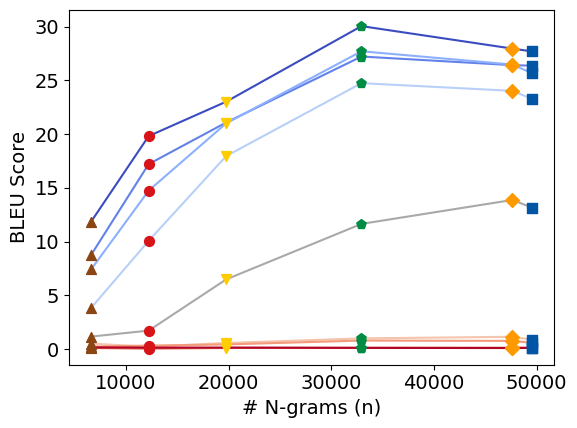

In [9]:
"""
This block is used to display
the language pairs that are available
"""

# for lang, df in lang_dfs_all.items():
#     print(f"{lang}: {len(df)}")

# # display top 100 of each language
# for lang, df in lang_dfs.items():
#     print(f"-------- lang: {lang} --------")
#     df = df.sort_values(by=['value'], ascending=False)
#     print(f"// top 100")
#     display(df.iloc[:100])
#     midpoint = np.median(df['value'])
#     print(f"// mid 100")
#     display(df[df['value'] <= midpoint].iloc[:100])

def get_model_results_from_df(df, scores, metric='bleu'):
    """"
    returns a dict of structure {task: {model:{scores, nsamples}}
    """
    model2score = {}
    dataset2score = {}
    score_keys = list(scores[list(scores.keys())[0]])
    print(score_keys)
    for model, model_results in df.items():
        for task in sorted(score_keys):
            if model not in model2score:
                model2score[model] = {'score': [], 'n_samples': []}
            if task not in dataset2score:
                dataset2score[task] = {'score': [], 'n_samples': []}
            if task not in model_results['task'].unique():
                task_key = task.split('-')
                task_key = f"{task_key[1]}-{task_key[0]}"
            else:
                task_key = task
            task_df = model_results[model_results['task'] == task_key]
            score_key = task
            print(f"model: {model}, task: {task}, score_key: {score_key}")
            task_score = scores[model][score_key]['bleu']
            task_n_samples = task_df['value'].sum()
            model2score[model]['score'].append(task_score)
            model2score[model]['n_samples'].append(task_n_samples)
            dataset2score[task]['score'].append(task_score)
            dataset2score[task]['n_samples'].append(task_n_samples)
    return model2score, dataset2score

def get_task_ngrams_from_df(df):
    first_model = list(df.keys())[0]
    examples = df[first_model] # the ngram vals are same for all models
    tasks = examples['task'].unique()
    task_ngrams = {}
    for task in tasks:
        task_ngrams[task] = {'score': [], 'n_samples': []}
        task_df = examples[examples['task'] == task]
        score = task_df.iloc[0]['bleu']
        # n_samples = 
        task_ngrams[task] = task_df
    return task_ngrams


model2score, dataset2score = get_model_results_from_df(lang_dfs, bleu_scores)
# task_ngrams = get_task_ngrams_from_df(lang_dfs)

# model colormap
model_colormap = plt.cm.get_cmap('coolwarm', len(models))
# model_color_mapping = {model: model_colormap(1 - i / len(models)) for i, model in enumerate(models)}
model_color_mapping = {model: model_colormap(i) for i, model in enumerate(models)}

# pythia 410m should be dark grey
model_color_mapping['pythia-410m'] = 'darkgrey'

# plot
wa.plot_scores(model2score, dataset2score, color_mapping,
               model_color_mapping, name=f"XY_pairs N-grams {N_GRAMS}")

# # plot each model on separate axis
# n_rows = 2
# fix, ax = plt.subplots(n_rows, (len(models) // n_rows) + 1, figsize=(15, 6))
# ax = ax.flatten()
# for i, model in enumerate(models):
#     show_legend = False if i != len(models) - 1 else True
#     show_xlabel = False if i == 0 else False
#     show_ylabel = False
#     model2score_model = {model: model2score[model]}
#     # keep only the corresponding score
#     dataset2score_model = collections.defaultdict(dict)
#     for task in dataset2score:
#         dataset2score_model[task]['score'] = [dataset2score[task]['score'][i]]
#         dataset2score_model[task]['n_samples'] = [dataset2score[task]['n_samples'][i]]
#     print(dataset2score_model)
#     wa.plot_scores(model2score_model, dataset2score_model, color_mapping,
#                    model_color_mapping, name=f"XY_pairs N-grams {N_GRAMS}",
#                    ax=ax[i], fit_polynomial=1, y_limits=[0, 27.5],
#                    show_legend=show_legend, show_xlabel=show_xlabel,
#                    show_ylabel=show_ylabel)
#     ax[i].set_title(f"Model: {model}")

In [12]:
dataset2score

{'cs-en': {'score': [19.811531414234153,
   17.20452796069501,
   14.73825342250829,
   10.069279262810534,
   1.7132795780981402,
   0.2171713606152602,
   0.321019992187086,
   0.041161758644288685,
   0.1353258763258698],
  'n_samples': [12216,
   12216,
   12216,
   12216,
   12216,
   12216,
   12216,
   12216,
   12216]},
 'de-en': {'score': [23.0096791252914,
   21.07238392555351,
   20.993743977671468,
   17.9478096415229,
   6.478345592107714,
   0.561689170644334,
   0.4264250933619905,
   0.10038087616119863,
   0.13759783666348852],
  'n_samples': [19763,
   19763,
   19763,
   19763,
   19763,
   19763,
   19763,
   19763,
   19763]},
 'es-en': {'score': [27.94768931635914,
   26.409698087795082,
   26.46390308719658,
   24.01719486772615,
   13.870980742558674,
   1.140065550869268,
   0.7561816846276739,
   0.11752950385324884,
   0.0939692087881113],
  'n_samples': [47658,
   47658,
   47658,
   47658,
   47658,
   47658,
   47658,
   47658,
   47658]},
 'fr-en': {'scor

In [11]:
for task in lang_df['task'].unique():
    lang_df_task = lang_df[lang_df['task'] == task]
    print(f"task: {task}")
    print(f"len rows: {len(lang_df_task)}")
    print(f"total_instances: {lang_df_task['value'].sum()}")
    if 'query' in lang_df_task.columns:
        display(lang_df_task)

task: cs-en
len rows: 927
total_instances: 134776


,lang_1,lang_2,value,example,task,pair,example_clean,docs,coverage,query,sum,count,id,gold,src,ref,result,bleu,alignment_score
0,a video,music video,39345,{'translation': {'cs': 'Vedle primárních funkc...,cs-en,"(a video, music video)","Vedle primárních funkcí, telefonování a esemes...","[train/01.jsonl.gz-5158242, train/02.jsonl.gz-...",0.033591,{'translation': {'cs': 'Vedle primárních funkc...,42796,2,1636_0,0,"Vedle primárních funkcí, telefonování a esemes...","In addition to the primary functions, calling ...","In addition to primary functions, telephony a...",32.912916,0.783287
8,the money,money money,25804,{'translation': {'cs': 'Problémem jsou pro ame...,cs-en,"(the money, money money)","Problémem jsou pro americké novináře peníze, t...","[train/00.jsonl.gz-5172182, train/04.jsonl.gz-...",0.033591,{'translation': {'cs': 'Problémem jsou pro ame...,25826,2,547_0,0,"Problémem jsou pro americké novináře peníze, t...",The problem for American journalists is the mo...,"The problem is for American journalists, the ...",35.591935,0.883030
12,film the,new film,23599,{'translation': {'cs': 'Podnětem pro tento duš...,cs-en,"(film the, new film)",Podnětem pro tento duševní striptýz byla PR pr...,"[train/01.jsonl.gz-5129100, train/06.jsonl.gz-...",0.033591,{'translation': {'cs': 'Podnětem pro tento duš...,24815,5,1913_0,0,Podnětem pro tento duševní striptýz byla PR pr...,The occasion for her candor was Ryan's promoti...,The inspiration for this film was the work of...,25.001526,0.770307
21,pravda,true,11121,"{'translation': {'cs': 'To je pravda.', 'en': ...",cs-en,"(pravda, true)",To je pravda.,"[train/02.jsonl.gz-5216935, train/07.jsonl.gz-...",0.033591,"{'translation': {'cs': 'To je pravda.', 'en': ...",11121,1,670_0,0,To je pravda.,It's true.,It is true.,31.947155,0.913461
54,the color,return color,3799,{'translation': {'cs': 'Zahořklý a pomstychtiv...,cs-en,"(the color, return color)",Zahořklý a pomstychtivý kulečníkový hráč v úža...,"[train/01.jsonl.gz-5143704, train/06.jsonl.gz-...",0.033591,{'translation': {'cs': 'Zahořklý a pomstychtiv...,5493,6,2738_0,0,Zahořklý a pomstychtivý kulečníkový hráč v úža...,Billiard player bitter and vengeful in the mag...,A hustler and a scoundrel in a great performa...,22.643847,0.789180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9673,bat out,bat hell,1,{'translation': {'cs': 'Ale Meat Loafovo album...,cs-en,"(bat out, bat hell)",Ale Meat Loafovo album Bat Out Of Hell se v že...,[train/14.jsonl.gz-3032514],0.033591,{'translation': {'cs': 'Ale Meat Loafovo album...,28,5,2297_0,0,Ale Meat Loafovo album Bat Out Of Hell se v že...,But Meat Loaf's Bat Out Of Hell album spent ar...,"""Bat Out Of Hell"" by Meat Loaf was number one...",20.422838,0.779481
9676,album bat,album spent,1,{'translation': {'cs': 'Ale Meat Loafovo album...,cs-en,"(album bat, album spent)",Ale Meat Loafovo album Bat Out Of Hell se v že...,[train/24.jsonl.gz-5962368],0.033591,{'translation': {'cs': 'Ale Meat Loafovo album...,28,5,2297_0,0,Ale Meat Loafovo album Bat Out Of Hell se v že...,But Meat Loaf's Bat Out Of Hell album spent ar...,"""Bat Out Of Hell"" by Meat Loaf was number one...",20.422838,0.814742
9682,internetová adresa,internet address,1,{'translation': {'cs': 'Na ní je nalevo švabac...,cs-en,"(internetová adresa, internet address)","Na ní je nalevo švabachem napsáno ""Oktoberfest...",[train/25.jsonl.gz-3658804],0.033591,{'translation': {'cs': 'Na ní je nalevo švabac...,3,2,399_0,0,"Na ní je nalevo švabachem napsáno ""Oktoberfest...","On the left side, they say `Oktoberfest' in Go...","""Oktoberfest"" is written on the left side of ...",13.917168,0.910201
9706,vojenskou základnu,military base,1,{'translation': {'cs': 'Rukojmí přiletěli okol...,cs-en,"(vojenskou základnu, military base)","Rukojmí přiletěli okolo 15.30, zjevně v dobré ...",[train/21.jsonl.gz-6661388],0.033591,{'translation': {'cs': 'Rukojmí přiletěli okol...,3,2,1414_0,0,"Rukojmí přiletěli okolo 15.30, zjevně v dob

task: fr-en
len rows: 1988
total_instances: 313314


,lang_1,lang_2,value,example,task,pair,example_clean,docs,coverage,query,sum,count,id,gold,src,ref,result,bleu,alignment_score
2,george bush,president george,28937,{'translation': {'en': 'The legislators thus i...,fr-en,"(george bush, president george)",Les législateurs renièrent ainsi l'appel au so...,"[train/00.jsonl.gz-5192953, train/07.jsonl.gz-...",0.072131,"{'translation': {'en': ""The legislators thus i...",28941,2,1898_8,0,The legislators thus ignored President George ...,Les législateurs renièrent ainsi l'appel au so...,Les législateurs ont ainsi ignoré l'appel du ...,8.839374,0.852806
7,the money,money money,25804,{'translation': {'en': 'The problem for Americ...,fr-en,"(the money, money money)","Le problème des journalistes américains, c'est...","[train/00.jsonl.gz-5172182, train/04.jsonl.gz-...",0.072131,{'translation': {'en': 'The problem for Americ...,25826,2,547_8,0,The problem for American journalists is the mo...,"Le problème des journalistes américains, c'est...","Le problème pour les journalistes américains,...",48.326978,0.883030
9,a question,question concerning,25057,{'translation': {'en': 'Answering the question...,fr-en,"(a question, question concerning)",A la question : qu'y aura-t-il dans cinq ans ?...,"[train/02.jsonl.gz-5068504, train/00.jsonl.gz-...",0.072131,{'translation': {'en': 'Answering the question...,44314,20,1900_8,0,Answering the question concerning his plans fo...,A la question : qu'y aura-t-il dans cinq ans ?...,Il souhaite que Google puisse répondre à des ...,27.715083,0.917543
11,film the,new film,23599,{'translation': {'en': 'The occasion for her c...,fr-en,"(film the, new film)",Le motif de ce striptease de la pensée réside ...,"[train/01.jsonl.gz-5129100, train/06.jsonl.gz-...",0.072131,"{'translation': {'en': ""The occasion for her c...",24853,6,1913_8,0,The occasion for her candor was Ryan's promoti...,Le motif de ce striptease de la pensée réside ...,L'occasion de sa franchise est le projet de f...,2.971988,0.770307
16,première fois,first time,18198,{'translation': {'en': 'So the publicity campa...,fr-en,"(première fois, first time)",Ainsi le battage publicitaire qui accompagnera...,"[train/01.jsonl.gz-5014854, train/11.jsonl.gz-...",0.072131,{'translation': {'en': 'So the publicity campa...,18213,3,553_8,0,So the publicity campaign that will accompany ...,Ainsi le battage publicitaire qui accompagnera...,La campagne de communication qui accompagnera...,24.473837,0.889363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9683,développement nord,sustainable development,1,{'translation': {'en': 'Northern development w...,fr-en,"(développement nord, sustainable development)",Le développement du Nord se ferait d'ailleurs ...,[train/19.jsonl.gz-2646561],0.072131,{'translation': {'en': 'Northern development w...,394,3,2894_8,0,Northern development would also be consistent ...,Le développement du Nord se ferait d'ailleurs ...,La développement du nord serait également coh...,17.511026,0.758708
9688,sans doute,otherwise likely,1,"{'translation': {'en': '""She was plainly other...",fr-en,"(sans doute, otherwise likely)","""Sans ceux-ci, elle serait sans doute aujourd'...",[train/06.jsonl.gz-4159166],0.072131,"{'translation': {'en': '""She was plainly other...",369,5,2582_8,0,"""She was plainly otherwise likely to have been...","""Sans ceux-ci, elle serait sans doute aujourd'...","""Elle était manifestement autrement susceptib...",5.600607,0.797411
9697,grandes compagnies,big international,1,"{'translation': {'en': 'It's an immense body, ...",fr-en,"(grandes compagnies, big international)",Voilà un gisement démesuré qui occupe plus de ...,[train/09.jsonl.gz-5590392],0.072131,"{'translation': {'en': ""It's an immense body, ...",3,2,653_8,0,"It's an immense body, that occupies 70% of the...",Voilà un gisement démesuré qui occupe plus de ...,"C'est un immense corps, qui occupe 70% de la ...",21.590098,0.753672
9699,plus services,presence services,1,"{'translation'

task: hu-en
len rows: 469
total_instances: 44211


,lang_1,lang_2,value,example,task,pair,example_clean,docs,coverage,query,sum,count,id,gold,src,ref,result,bleu,alignment_score
3,george bush,president george,28937,{'translation': {'en': 'The legislators thus i...,hu-en,"(george bush, president george)",A törvényhozók ezáltal figyelmen kívül hagyták...,"[train/00.jsonl.gz-5192953, train/07.jsonl.gz-...",0.019848,"{'translation': {'en': ""The legislators thus i...",28937,1,1898_11,0,The legislators thus ignored President George ...,A törvényhozók ezáltal figyelmen kívül hagyták...,A kormányzók így figyelmen kívül hagyott a Bi...,7.175378,0.852806
88,évvel ezelőtt,years ago,2013,"{'translation': {'en': 'Frequently, it is hist...",hu-en,"(évvel ezelőtt, years ago)",Amikor történelmi és emlékekkel teli helyek tű...,"[train/14.jsonl.gz-1116495, train/05.jsonl.gz-...",0.019848,"{'translation': {'en': 'Frequently, it is hist...",2124,9,49_11,0,"Frequently, it is historical places which are ...",Amikor történelmi és emlékekkel teli helyek tű...,"A történelmi helyek, amelyek a történelmi eml...",1.391004,0.908527
154,j d,professor j,1057,{'translation': {'en': 'From 1946 to 1953 he w...,hu-en,"(j d, professor j)",1946 és 1953 között a Nottinghami Egyetemen ok...,"[train/07.jsonl.gz-5973639, train/03.jsonl.gz-...",0.019848,{'translation': {'en': 'From 1946 to 1953 he w...,1278,3,2110_11,0,From 1946 to 1953 he was a lecturer in economi...,1946 és 1953 között a Nottinghami Egyetemen ok...,1945–1953 he was a lecturer in economic histo...,8.861776,0.817393
157,jelent,means,1044,"{'translation': {'en': 'What this means?', 'hu...",hu-en,"(jelent, means)",Hogy ez mit jelent?,"[train/06.jsonl.gz-305355, train/00.jsonl.gz-1...",0.019848,"{'translation': {'en': 'What this means?', 'hu...",1044,1,2701_11,0,What this means?,Hogy ez mit jelent?,Mit jelent ez?,16.372270,0.882400
189,kevesebb,less,843,"{'translation': {'en': 'Less is more.', 'hu': ...",hu-en,"(kevesebb, less)",A kevesebb néha több.,"[train/00.jsonl.gz-5605348, train/05.jsonl.gz-...",0.019848,"{'translation': {'en': 'Less is more.', 'hu': ...",843,1,408_11,0,Less is more.,A kevesebb néha több.,"Kis több, kevesebb.",14.058533,0.931803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9472,bat out,bat hell,1,{'translation': {'en': 'But Meat Loaf's Bat Ou...,hu-en,"(bat out, bat hell)","Azonban Meat Loaf ""Bat Out Of Hell"" című album...",[train/14.jsonl.gz-3032514],0.019848,"{'translation': {'en': ""But Meat Loaf's Bat Ou...",284,8,2297_11,0,But Meat Loaf's Bat Out Of Hell album spent ar...,"Azonban Meat Loaf ""Bat Out Of Hell"" című album...",De Bat-kutya a Holdból született.,0.126676,0.779481
9520,európai unió,union shall,1,{'translation': {'en': 'What we need in the lo...,hu-en,"(európai unió, union shall)","Hosszú távon arra van szükség, hogy az Európai...",[train/15.jsonl.gz-2487121],0.019848,{'translation': {'en': 'What we need in the lo...,52,2,2687_11,0,What we need in the long term is that the memb...,"Hosszú távon arra van szükség, hogy az Európai...",A jövőben az EU tagállamai maguknak kell megh...,8.775876,0.791945
9540,brit bank,british bank,1,{'translation': {'en': 'The Spanish bank Santa...,hu-en,"(brit bank, british bank)","A spanyol Santander bank tegnap bejelentette, ...",[train/03.jsonl.gz-6438428],0.019848,{'translation': {'en': 'The Spanish bank Santa...,190,4,1568_11,0,The Spanish bank Santander has indicated yeste...,"A spanyol Santander bank tegnap bejelentette, ...","A spanyol bankoknak jelentkezik, hogy a brit ...",7.683107,0.958849
9617,aac apple,used apple,1,{'translation': {'en': 'Less common is the app...,hu-en,"(aac apple, used apple)",Az AAC (az Apple cég által és iPodjára használ...,[train/18.jsonl.gz-3899207],0.019848,{'translation': {'en': 'Less common is the app...,22,3,919_11,0,Less common is the appearance of AAC (the form...,Az AAC (az Apple cég által és iPodjára használ...,"Kisebb a kisbetűk száma (lit. ""smaller number...",1.826473,0.837684


task: de-en
len rows: 983
total_instances: 162989


,lang_1,lang_2,value,example,task,pair,example_clean,docs,coverage,query,sum,count,id,gold,src,ref,result,bleu,alignment_score
4,musik,music,27290,{'translation': {'de': 'Es ist alles in der Mu...,de-en,"(musik, music)",Es ist alles in der Musik.,"[train/04.jsonl.gz-5279853, train/00.jsonl.gz-...",0.038317,{'translation': {'de': 'Es ist alles in der Mu...,27290,1,2012_1,0,Es ist alles in der Musik.,It's all there in the music.,It's all in the music.,51.150781,0.980885
13,film the,new film,23599,{'translation': {'de': 'Anlass für den Seelens...,de-en,"(film the, new film)",Anlass für den Seelenstriptease war Ryans Pres...,"[train/01.jsonl.gz-5129100, train/06.jsonl.gz-...",0.038317,{'translation': {'de': 'Anlass für den Seelens...,24822,5,1913_1,0,Anlass für den Seelenstriptease war Ryans Pres...,The occasion for her candor was Ryan's promoti...,The reason for the soul stripping was Ryan's ...,11.665452,0.770307
14,new yorker,new yorkers,19896,{'translation': {'de': 'Ganz normale New Yorke...,de-en,"(new yorker, new yorkers)",Ganz normale New Yorker haben sich in den letz...,"[train/06.jsonl.gz-5159988, train/07.jsonl.gz-...",0.038317,{'translation': {'de': 'Ganz normale New Yorke...,20236,3,652_1,0,Ganz normale New Yorker haben sich in den letz...,Ordinary New Yorkers in the last few weeks hav...,The New Yorkers who have been speaking fluent...,15.807438,0.964260
27,music player,music players,8482,{'translation': {'de': 'In dieser Hinsicht sin...,de-en,"(music player, music players)",In dieser Hinsicht sind Music Player (speziell...,"[train/09.jsonl.gz-1499802, train/09.jsonl.gz-...",0.038317,{'translation': {'de': 'In dieser Hinsicht sin...,8639,3,1931_1,0,In dieser Hinsicht sind Music Player (speziell...,"In this way, music players (particularly the s...","In this respect, music players (especially th...",40.652204,0.943986
33,vielleicht,maybe,5954,"{'translation': {'de': 'Vielleicht', 'en': 'Ma...",de-en,"(vielleicht, maybe)",Vielleicht,"[train/01.jsonl.gz-5129092, train/01.jsonl.gz-...",0.038317,"{'translation': {'de': 'Vielleicht', 'en': 'Ma...",5954,1,378_1,0,Aus nicht offiziellen Informationen geht hervo...,"On the basis of unofficial information, it loo...",From unofficial information it is known that ...,11.907924,0.880339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9644,neue tschechische,czech national,1,{'translation': {'de': 'Die neue tschechische ...,de-en,"(neue tschechische, czech national)",Die neue tschechische Hymne hat vier neue Vers...,[train/00.jsonl.gz-4766658],0.038317,{'translation': {'de': 'Die neue tschechische ...,27,4,2160_1,0,Die neue tschechische Hymne hat vier neue Vers...,New Czech national anthem has four new versions.,The new Czech hymn has four new versions.,46.713798,0.836941
9650,neue tschechische,new czech,1,{'translation': {'de': 'Die neue tschechische ...,de-en,"(neue tschechische, new czech)",Die neue tschechische Hymne hat vier neue Vers...,[train/00.jsonl.gz-4766658],0.038317,{'translation': {'de': 'Die neue tschechische ...,27,4,2160_1,0,Die neue tschechische Hymne hat vier neue Vers...,New Czech national anthem has four new versions.,The new Czech hymn has four new versions.,46.713798,0.939140
9655,mehr zwei,two thirds,1,{'translation': {'de': 'Seit Jänner sank der W...,de-en,"(mehr zwei, two thirds)",Seit Jänner sank der Wert der Aktien um mehr a...,[train/23.jsonl.gz-238357],0.038317,{'translation': {'de': 'Seit Jänner sank der W...,353,2,1563_1,0,Seit Jänner sank der Wert der Aktien um mehr a...,The value of the shares has been dropped by tw...,Since January the value of shares has fallen ...,11.177547,0.814601
9661,bisherigen ergebnissen,preliminary results,1,{'translation': {'de': 'Den bisherigen Ergebni...,de-en,"(bisherigen ergebnissen, preliminary results)",Den bisherigen Ergebnissen zufolge bleibt die ...,[train/11.jsonl.gz-6263220],0.038317,{'translation': {'de': 'Den bisherigen Ergebni...,3,2,1154_1,0,Den bisherigen Ergebnissen zufolge 

task: es-en
len rows: 1757
total_instances: 227641


,lang_1,lang_2,value,example,task,pair,example_clean,docs,coverage,query,sum,count,id,gold,src,ref,result,bleu,alignment_score
5,the money,money money,25804,{'translation': {'en': 'The problem for Americ...,es-en,"(the money, money money)",El problema para los periodistas estadounidens...,"[train/00.jsonl.gz-5172182, train/04.jsonl.gz-...",0.056007,{'translation': {'en': 'The problem for Americ...,25836,4,547_9,0,The problem for American journalists is the mo...,El problema para los periodistas estadounidens...,El problema para los periodistas estadouniden...,75.392212,0.883030
18,menos,less,16043,"{'translation': {'en': 'Less is more.', 'es': ...",es-en,"(menos, less)",Menos es más.,"[train/01.jsonl.gz-5014854, train/07.jsonl.gz-...",0.056007,"{'translation': {'en': 'Less is more.', 'es': ...",16043,1,408_9,0,Less is more.,Menos es más.,Más es menos.,18.995892,0.934010
25,verdad,true,8932,"{'translation': {'en': 'It's true.', 'es': 'Es...",es-en,"(verdad, true)",Es verdad.,"[train/05.jsonl.gz-5046819, train/07.jsonl.gz-...",0.056007,"{'translation': {'en': ""It's true."", 'es': 'Es...",8932,1,670_9,0,It's true.,Es verdad.,Es cierto.,34.668064,0.949675
26,dos años,two years,8820,{'translation': {'en': 'Two years on there are...,es-en,"(dos años, two years)",A dos años de distancia a apostar sobre la ene...,"[train/10.jsonl.gz-589246, train/12.jsonl.gz-8...",0.056007,{'translation': {'en': 'Two years on there are...,8820,1,203_9,0,Two years on there are more companies betting ...,A dos años de distancia a apostar sobre la ene...,Dos años después hay más empresas apostando e...,15.336299,0.978303
29,año pasado,last year,7770,{'translation': {'en': 'Within the framework o...,es-en,"(año pasado, last year)",El objetivo de la Cumbre Europea para la Igual...,"[train/07.jsonl.gz-5364681, train/05.jsonl.gz-...",0.056007,{'translation': {'en': 'Within the framework o...,7808,6,2266_9,0,"Within the framework of the ""European Year of ...",El objetivo de la Cumbre Europea para la Igual...,"En el marco de la ""Europa de los derechos hum...",8.362113,0.949726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9663,consumo petróleo,oil consumption,1,{'translation': {'en': 'The bank's analysts pa...,es-en,"(consumo petróleo, oil consumption)",Los analistas del banco han reducido sus expec...,[train/14.jsonl.gz-1167236],0.056007,"{'translation': {'en': ""The bank's analysts pa...",315,4,2958_9,0,The bank's analysts pared down their expectati...,Los analistas del banco han reducido sus expec...,Los analistas del banco redujeron sus expecta...,16.872643,0.941827
9679,crisis económica,societies economic,1,{'translation': {'en': 'One gets the impressio...,es-en,"(crisis económica, societies economic)",Se tiene la impresión que las elites tradicion...,[train/00.jsonl.gz-1560856],0.056007,{'translation': {'en': 'One gets the impressio...,368,4,2379_9,0,One gets the impression that the traditional e...,Se tiene la impresión que las elites tradicion...,"Se nota que la élite tradicional, sus partido...",34.331108,0.800057
9680,rescate financiero,rescue package,1,{'translation': {'en': 'After several days of ...,es-en,"(rescate financiero, rescue package)",Los representantes del Congreso y de la admini...,[train/17.jsonl.gz-6168663],0.056007,{'translation': {'en': 'After several days of ...,397,2,42_9,0,"After several days of marathon negotiations, t...",Los representantes del Congreso y de la admini...,Después de varios días de negociaciones de má...,19.632651,0.808523
9695,muchas estrellas,many worlds,1,{'translation': {'en': 'He has come under some...,es-en,"(muchas estrellas, many worlds)",El atleta ha sido objeto de algunas críticas -...,[train/18.jsonl.gz-6596717],0.056007,"{'translation': {'en': ""He has come under some...",3,2,1015_9,0,He has come under some criticism - especially ...,El atleta ha sido objeto de algunas críticas -...,"Ha sido criticado - especialmente en Kenia, l...",10.703512,0.763683


task: it-en
len rows: 1416
total_instances: 213285


,lang_1,lang_2,value,example,task,pair,example_clean,docs,coverage,query,sum,count,id,gold,src,ref,result,bleu,alignment_score
6,the money,money money,25804,{'translation': {'en': 'The problem for Americ...,it-en,"(the money, money money)",Il problema per i giornalisti statunitensi è i...,"[train/00.jsonl.gz-5172182, train/04.jsonl.gz-...",0.047121,{'translation': {'en': 'The problem for Americ...,25828,3,547_10,0,The problem for American journalists is the mo...,Il problema per i giornalisti statunitensi è i...,Il problema per i giornalisti americani è il ...,49.735674,0.883030
10,film the,new film,23599,{'translation': {'en': 'The occasion for her c...,it-en,"(film the, new film)","L'occasione per lo ""spogliarello dell'anima"" è...","[train/01.jsonl.gz-5129100, train/06.jsonl.gz-...",0.047121,"{'translation': {'en': ""The occasion for her c...",24825,5,1913_10,0,The occasion for her candor was Ryan's promoti...,"L'occasione per lo ""spogliarello dell'anima"" è...",L'occasione per la sua onestà fu il suo rilas...,8.957367,0.770307
15,vero,true,19425,"{'translation': {'en': 'It's true.', 'it': 'È ...",it-en,"(vero, true)",È vero.,"[train/03.jsonl.gz-5134492, train/03.jsonl.gz-...",0.047121,"{'translation': {'en': ""It's true."", 'it': 'È ...",19425,1,293_10,0,"Mr. Obama's campaign notes that, ""African-Amer...","La campagna del signor Obama nota che, ""gli st...","Mr. Obama's campaign notes that, ""African-Ame...",3.579031,0.940371
17,prima volta,first time,16544,{'translation': {'en': 'So the publicity campa...,it-en,"(prima volta, first time)",Così il battage pubblicitario che accompagnerà...,"[train/11.jsonl.gz-556600, train/14.jsonl.gz-6...",0.047121,{'translation': {'en': 'So the publicity campa...,16595,2,553_10,0,So the publicity campaign that will accompany ...,Così il battage pubblicitario che accompagnerà...,La campagna pubblicitaria che accompagnerà la...,20.679845,0.860202
20,sim card,sim cards,11722,{'translation': {'en': 'The trick lies in the ...,it-en,"(sim card, sim cards)",La magia sta nel fatto che l'azienda nei confr...,"[train/00.jsonl.gz-5143078, train/04.jsonl.gz-...",0.047121,{'translation': {'en': 'The trick lies in the ...,11729,3,167_10,0,"The trick lies in the fact that, in relation t...",La magia sta nel fatto che l'azienda nei confr...,"Il trucco sta nel fatto che, in relazione all...",13.796621,0.814734
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,meat loaf,loafs bat,1,{'translation': {'en': 'But Meat Loaf's Bat Ou...,it-en,"(meat loaf, loafs bat)",Ma l'album di Meat Loaf Bat Out Of Hell rimase...,[train/20.jsonl.gz-4522850],0.047121,"{'translation': {'en': ""But Meat Loaf's Bat Ou...",392,10,2297_10,0,But Meat Loaf's Bat Out Of Hell album spent ar...,Ma l'album di Meat Loaf Bat Out Of Hell rimase...,Ma il disco di Meat Loaf Bat Out Of Hell è st...,34.519376,0.759848
9701,loaf bat,meat loafs,1,{'translation': {'en': 'But Meat Loaf's Bat Ou...,it-en,"(loaf bat, meat loafs)",Ma l'album di Meat Loaf Bat Out Of Hell rimase...,[train/20.jsonl.gz-4522850],0.047121,"{'translation': {'en': ""But Meat Loaf's Bat Ou...",392,10,2297_10,0,But Meat Loaf's Bat Out Of Hell album spent ar...,Ma l'album di Meat Loaf Bat Out Of Hell rimase...,Ma il disco di Meat Loaf Bat Out Of Hell è st...,34.519376,0.789515
9702,bat out,bat hell,1,{'translation': {'en': 'But Meat Loaf's Bat Ou...,it-en,"(bat out, bat hell)",Ma l'album di Meat Loaf Bat Out Of Hell rimase...,[train/14.jsonl.gz-3032514],0.047121,"{'translation': {'en': ""But Meat Loaf's Bat Ou...",392,10,2297_10,0,But Meat Loaf's Bat Out Of Hell album spent ar...,Ma l'album di Meat Loaf Bat Out Of Hell rimase...,Ma il disco di Meat Loaf Bat Out Of Hell è st...,34.519376,0.779481
9703,loaf bat,loafs bat,1,{'translation': {'en': 'But Meat Loaf's Bat Ou...,it-en,"(loaf bat, loafs bat)",Ma l'album di Meat Loaf Bat Out Of Hell rimase...,[train/20.jsonl.gz-4522850],0.047121,"{'translation': {'en': ""But Meat Loaf's Bat Ou...",392,